In [2]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import nums_from_string
from sklearn.model_selection import train_test_split

In [95]:
def get_redshifts(filelist, number_of_images = 57720, rot = False, flip = False):
    num_string = nums_from_string.get_nums(filelist[0])
    if len(num_string) == 2:
        z = np.array(num_string[1])
    if len(num_string) == 3:
        z = np.array(num_string[1]*10**(num_string[2]))
    if rot:
        for j in [1,2,3]:
            if len(num_string) == 2:
                z = np.append(z, num_string[1])
            if len(num_string) == 3:
                z = np.append(z, num_string[1]*10**(num_string[2]))
    if flip:
        if len(num_string) == 2:
            z = np.append(z, num_string[1])
        if len(num_string) == 3:
            z = np.append(z, num_string[1]*10**(num_string[2]))
        if rot:
            for j in [1,2,3]:
                if len(num_string) == 2:
                    z = np.append(z, num_string[1])
                if len(num_string) == 3:
                    z = np.append(z, num_string[1]*10**(num_string[2]))
    for i in np.arange(1,number_of_images):
        num_string = nums_from_string.get_nums(filelist[i])
        if len(num_string) == 2:
            z = np.append(z, num_string[1])
        if len(num_string) == 3:
            z = np.append(z, num_string[1]*10**(num_string[2]))
        if rot:
            for j in [1,2,3]:
                if len(num_string) == 2:
                    z = np.append(z, num_string[1])
                if len(num_string) == 3:
                    z = np.append(z, num_string[1]*10**(num_string[2]))
        if flip:
            if len(num_string) == 2:
                z = np.append(z, num_string[1])
            if len(num_string) == 3:
                z = np.append(z, num_string[1]*10**(num_string[2]))
            if rot:
                for j in [1,2,3]:
                    if len(num_string) == 2:
                        z = np.append(z, num_string[1])
                    if len(num_string) == 3:
                        z = np.append(z, num_string[1]*10**(num_string[2]))              
    return z

def get_images(filelist, number_of_images = 57720, rot = False, flip = False):
    _ = np.expand_dims(mpimg.imread(filelist[0]).astype(float), axis = 0)
    jpgs = _
    
    if rot:
        for j in [1,2,3]:
            _ = np.rot90(_, j, axes = (1,2))
            jpgs = np.concatenate((jpgs, _))
                
    if flip:
        _ = np.flip(_, 1)
        jpgs = np.concatenate((jpgs, _))
        if rot:
            for j in [1,2,3]:
                _ = np.rot90(_, j, axes = (1,2))
                jpgs = np.concatenate((jpgs, _))
                
    x=1
    y=1
    w = number_of_images
    mod = w/100
    
    for i in filelist[1:number_of_images]:
        
        if int(x % mod) == 0:
            print(y)
            y = y+1
        
        _ = np.expand_dims(mpimg.imread(i), axis = 0)
        jpgs = np.concatenate((jpgs, _))
        
        if rot:
            for j in [1,2,3]:
                _ = np.rot90(_, j, axes = (1,2))
                jpgs = np.concatenate((jpgs, _))
                
        if flip:
            _ = np.flip(_, 1)
            jpgs = np.concatenate((jpgs, _))
            if rot:
                for j in [1,2,3]:
                    _ = np.rot90(_, j, axes = (1,2))
                    jpgs = np.concatenate((jpgs, _))
        x = x+1
                    
    z = get_redshifts(filelist, number_of_images, rot, flip)
    return jpgs, z
    
def center_crop(a, width = 60):
    x = int(36-width/2)
    y = int(36+width/2)
    a = a[:,x:y,x:y,:]
    return a

def random_crop(a, width = 60):
    m = width/2
    n = 72 - width/2
    b = np.zeros((len(a), width, width, 3))
    for i in np.arange(len(b)):
        z = np.random.randint(m,n)
        x = int(z-width/2)
        y = int(z+width/2)
        b[i] = a[i,x:y,x:y,:]
    return b

def crop(a, width = 60):
    m = width//2
    n = 72 - width//2
    b = np.zeros((len(a), width, width, 3))
    c = np.zeros((width, width))
    for i in np.arange(len(a)):
        c = np.sum(a[i], axis = 2)
        ind = list(np.unravel_index(np.argmax(c, axis=None), c.shape))
       	for j in [0,1]:
            if ind[j] < m:
                ind[j] = m
            elif ind[j] > n:
                ind[j] = n
        x0 = ind[0]-m
        x1 = x0+width
        y0 = ind[1]-m
        y1 = y0+width
        b[i] = a[i,x0:x1,y0:y1,:]
    return b
    
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def rescaling(data):
    data = data
    for i in np.arange(len(data)):
        data[i] = np.amax(data[i]) - data[i]
        data[i] = data[i] / np.amax(data[i])
    return data

def reshape(a, width):
    length = len(a)
    return np.reshape(a, (length,(width**2)*3))

def split(data, targets, trainsplit = 0.6, valsplit = 0.2, shuffle=True):
    train, test, traintar, testtar = train_test_split(data, targets, train_size=trainsplit+valsplit, shuffle=shuffle)
    train, val, traintar, valtar = train_test_split(train, traintar, train_size=trainsplit/(trainsplit+valsplit), shuffle=shuffle) 
    return train, val, test, traintar, valtar, testtar

def data_prep(num = 57720, width = 60, train_split= 0.6, val_split = 0.2, rot = False, flip = False, shuf = False, ran_crop = False, cen_crop = False):
    # np.random.seed(1684)
    filelist = glob.glob("sdss_images/*.jpg")
    print('Reading Data')
    dat, tar = get_images(filelist, num, rot, flip)
    print('Rescaling')
    dat = rescaling(dat)
    print('Cropping images')
    if ran_crop:
        dat = random_crop(dat, width)
    elif cen_crop:
        dat = center_crop(dat, width)   
    else:
        dat = crop(dat, width)
    if shuf:
        dat, tar = unison_shuffle(dat, tar)
    dat = reshape(dat,width)
    print('Spliting Data')
    if shuf:
        train, val, testtest, train_tar, val_tar, test_tar = split(dat, tar, train_split, val_split, shuffle = False)
    else:
        train, val, testtest, train_tar, val_tar, test_tar = split(dat, tar, train_split, val_split)
    return train, val, testtest, train_tar, val_tar, test_tar

In [4]:
train, val, test, train_tar, val_tar, test_tar = data_prep(num = 5000, width = 60)
print(np.shape(train), np.shape(val), np.shape(test), np.shape(train_tar), np.shape(val_tar), np.shape(test_tar))

(2999, 10800) (1001, 10800) (1000, 10800) (2999,) (1001,) (1000,)


In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [6]:
def objective(hyperparameters):
    if hyperparameters['max_depth'] == 0:
        hyperparameters['max_depth'] = 1
    if hyperparameters['n_estimators'] == 0:
        hyperparameters['n_estimators'] = 1
    if hyperparameters['min_samples_split'] == 0:
        hyperparameters['min_samples_split'] = 1
    if hyperparameters['min_samples_leaf'] == 0:
        hyperparameters['min_samples_leaf'] = 1
    gbr = GradientBoostingRegressor(**hyperparameters)
    gbr.fit(train, train_tar)
    
    a = gbr.predict(val)
    b = val_tar
    c = np.sum(np.sqrt(np.abs(a-b)))
    
    return {'loss':c, 'status': STATUS_OK}

In [7]:
space ={
    'loss': hp.choice('loss', ['ls', 'huber', 'lad']),
    'criterion': hp.choice('criterion', ['friedman_mse', 'mse']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.4)),
    'n_estimators': hp.randint('n_estimators', 150),
    'min_samples_split': hp.randint('min_samples_split', 50),
    'min_samples_leaf': hp.randint('min_samples_leaf', 51),
    'max_depth': hp.randint('max_depth', 16)
}

In [8]:
bayes_trials = Trials()

In [9]:
tpe_alg = tpe.suggest

In [13]:
MAX_EVALS = 50

best = fmin(objective, space = space, 
            algo = tpe.suggest, max_evals=MAX_EVALS, trials=bayes_trials)

100%|█████████████████████████████████████████████| 50/50 [7:27:56<00:00, 959.88s/trial, best loss: 189.47972682302768]


In [16]:
print(best)

{'criterion': 0, 'learning_rate': 0.05184643843759477, 'loss': 1, 'max_depth': 14, 'min_samples_leaf': 12, 'min_samples_split': 43, 'n_estimators': 77}


In [18]:
gbr1 = GradientBoostingRegressor(loss = 'huber', criterion='friedman_mse', 
                                 learning_rate = 0.52, max_depth = 14, min_samples_leaf=12, 
                                 min_samples_split=43, n_estimators=77)
gbr1.fit(train, train_tar)

GradientBoostingRegressor(learning_rate=0.52, loss='huber', max_depth=14,
                          min_samples_leaf=12, min_samples_split=43,
                          n_estimators=77)

In [99]:
pred_val = gbr1.predict(val)
devia = np.abs(pred - val_tar)
devia_perc = devia / val_tar
print(devia_perc)
np.sqrt(np.mean(devia**2))

[0.1565693  0.16869738 0.14757276 ... 0.46522716 0.44723541 0.01768261]


0.48714080055029674

Text(0.5, 0, 'deviation')

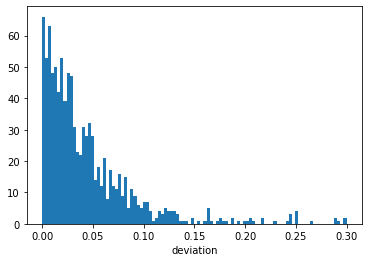

In [100]:
plt.hist(devia, 100, (0,0.3))
plt.xlabel('deviation')

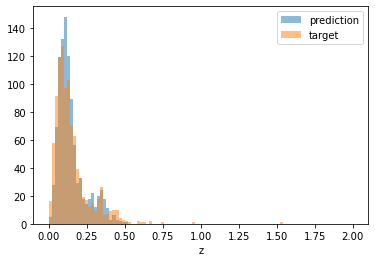

In [102]:
plt.hist(pred_val,100, (0,1), alpha = 0.5, label = 'prediction')
plt.hist(val_tar,100, (0,1), alpha = 0.5, label = 'target')
plt.xlabel('z')
plt.legend()
plt.savefig('Val_Dist')

Text(0.5, 1.0, 'Validation')

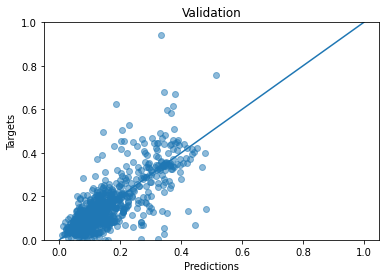

In [105]:
plt.scatter(pred_val, val_tar, alpha = 0.4)
plt.plot([0,1],[0,1], colors = 'black')
plt.xlabel('Predictions')
plt.xlim((0,1))
plt.ylim((0,1))
plt.ylabel('Targets')
plt.title('Validation')
plt.savefig('Val_Pedict')

Text(0.5, 1.0, 'Test')

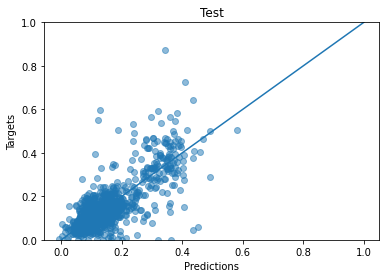

In [112]:
pred_test = gbr1.predict(test)
plt.scatter(pred_test, test_tar, alpha = 0.4, colors = 'black')
plt.plot([0,1],[0,1])
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.title('Test')
plt.savefig('Test_Predict')

In [113]:
train_f, val_f, test_f, train_tar_f, val_tar_f, test_tar_f = data_prep(train_split=0.8, val_split=0.001)

Reading Data
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Rescaling
Cropping images
Spliting Data


In [114]:
gbr_f = GradientBoostingRegressor(loss = 'huber', criterion='friedman_mse', 
                                 learning_rate = 0.52, max_depth = 14, min_samples_leaf=12, 
                                 min_samples_split=43, n_estimators=77)
gbr_f.fit(train_f, train_tar_f)

GradientBoostingRegressor(learning_rate=0.52, loss='huber', max_depth=14,
                          min_samples_leaf=12, min_samples_split=43,
                          n_estimators=77)

In [94]:
print(train_tar_f)

[1.07629e-01 9.32712e-02 2.96518e-02 6.27670e-02 1.77191e-01 3.78682e-01
 2.45329e-01 2.01028e-01 1.85275e-01 1.54909e-01 4.26993e-01 1.01232e-01
 4.11659e-01 1.54206e-01 8.64655e-02 1.35554e-01 1.65802e-01 3.40599e-01
 9.42061e-02 2.03224e-01 2.14548e-01 7.45248e-02 2.80704e-02 6.06830e-02
 7.97516e-02 1.93469e-01 1.92091e-01 1.02789e-01 2.42140e-01 7.23853e-02
 1.13293e-01 1.55562e-01 6.21721e-02 1.21154e-01 9.35557e-02 1.91654e-01
 1.54030e-01 8.06582e-02 1.74050e-01 1.21902e-01 1.16919e-04 3.97817e-01
 3.69824e-01 8.26984e-02 3.72977e-01 2.07861e-01 1.02818e-01 8.06183e-02
 1.56971e-01 1.96482e-01 2.65986e-01 9.85964e-02 8.14887e-02 1.02503e-01
 5.50072e-02 2.29181e-05 9.87905e-02 1.27305e-01 1.41100e-01 1.28601e-01
 9.91663e-02 8.62614e-02 1.02663e-01 8.35386e-02 6.70942e-02 9.58625e-02
 2.42678e-01 2.00655e-01 9.27522e-02 7.82815e-02 1.22900e-01 1.03157e-01
 1.82126e-01 8.26856e-02 8.72169e-02 3.62558e-01 6.28708e-01 6.18287e-02
 4.14493e-02]


In [ ]:
pred_test_f = gbr_f.predict(test_f)
plt.scatter(test_tar_f, pred_test_f, alpha = 0.4)
plt.plot([0,1],[0,1], color = 'black')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.title('Test Final Run')
plt.savefig('Test_Predict_f')

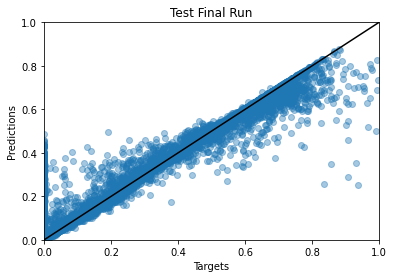

In [125]:
pred_train_f = gbr_f.predict(train_f)
plt.scatter(train_tar_f, pred_train_f, alpha = 0.4)
plt.plot([0,1],[0,1], color = 'black')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.title('Test Final Run')
plt.savefig('Train_Predict_f')

In [ ]:
gbr_f_1 = GradientBoostingRegressor(loss = 'huber', criterion='friedman_mse', 
                                 learning_rate = 0.52, max_depth = 14, min_samples_leaf=180, 
                                 min_samples_split=650, n_estimators=77)
gbr_f_1.fit(train_f, train_tar_f)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import nums_from_string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from statistics import mode, median
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import tensorflow as tf

def createHoyleModel():
    model = Sequential()
    model.add(Conv2D(10, (3, 3), padding='same', activation='relu', input_shape=(60,60,3)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
#    these two layers causes negative dimension size
#    model.add(Conv2D(256, (3, 3), activation='relu'))
#    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(3969, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(100, activation='softmax'))
    return model



In [2]:
def oneHot(inputArray,nbins):
    indices = np.zeros((len(inputArray),2),dtype=int)
    indices[:, 0] = np.arange(0,len(inputArray))
    indices[:, 1] = np.around(inputArray * nbins).astype(int)
    oneHot = np.zeros((len(inputArray),nbins))
    oneHot[indices[:,0],indices[:,1]] = 1.0
    return oneHot

In [4]:
def get_redshifts(filelist, number_of_images = 57720, rot = False, flip = False):
    num_string = nums_from_string.get_nums(filelist[0])
    if len(num_string) == 2:
        z = np.array(num_string[1])
    if len(num_string) == 3:
        z = np.array(num_string[1]*10**(num_string[2]))
    if rot:
        for j in [1,2,3]:
            if len(num_string) == 2:
                z = np.append(z, num_string[1])
            if len(num_string) == 3:
                z = np.append(z, num_string[1]*10**(num_string[2]))
    if flip:
        if len(num_string) == 2:
            z = np.append(z, num_string[1])
        if len(num_string) == 3:
            z = np.append(z, num_string[1]*10**(num_string[2]))
        if rot:
            for j in [1,2,3]:
                if len(num_string) == 2:
                    z = np.append(z, num_string[1])
                if len(num_string) == 3:
                    z = np.append(z, num_string[1]*10**(num_string[2]))
    for i in np.arange(1,number_of_images):
        num_string = nums_from_string.get_nums(filelist[i])
        if len(num_string) == 2:
            z = np.append(z, num_string[1])
        if len(num_string) == 3:
            z = np.append(z, num_string[1]*10**(num_string[2]))
        if rot:
            for j in [1,2,3]:
                if len(num_string) == 2:
                    z = np.append(z, num_string[1])
                if len(num_string) == 3:
                    z = np.append(z, num_string[1]*10**(num_string[2]))
        if flip:
            if len(num_string) == 2:
                z = np.append(z, num_string[1])
            if len(num_string) == 3:
                z = np.append(z, num_string[1]*10**(num_string[2]))
            if rot:
                for j in [1,2,3]:
                    if len(num_string) == 2:
                        z = np.append(z, num_string[1])
                    if len(num_string) == 3:
                        z = np.append(z, num_string[1]*10**(num_string[2]))              
    return z

def get_images(filelist, number_of_images = 57720, rot = False, flip = False):
    _ = np.expand_dims(mpimg.imread(filelist[0]).astype(float), axis = 0)
    jpgs = []
    jpgs.append(_)
    
    if rot:
        for j in [1,2,3]:
            _ = np.rot90(_, j, axes = (1,2))
            jpgs = np.concatenate((jpgs, _))
                
    if flip:
        _ = np.flip(_, 1)
        jpgs = np.concatenate((jpgs, _))
        if rot:
            for j in [1,2,3]:
                _ = np.rot90(_, j, axes = (1,2))
                jpgs = np.concatenate((jpgs, _))
                
    x=1
    y=1
    w = number_of_images
    mod = w/100
    
    for i in filelist[1:number_of_images]:
        
        if int(x % mod) == 0:
            print(y)
            y = y+1
        
        _ = np.expand_dims(mpimg.imread(i), axis = 0)
        jpgs.append(_)
        
        if rot:
            for j in [1,2,3]:
                _ = np.rot90(_, j, axes = (1,2))
                jpgs = np.concatenate((jpgs, _))
                
        if flip:
            _ = np.flip(_, 1)
            jpgs = np.concatenate((jpgs, _))
            if rot:
                for j in [1,2,3]:
                    _ = np.rot90(_, j, axes = (1,2))
                    jpgs = np.concatenate((jpgs, _))
        x = x+1
                    
    z = get_redshifts(filelist, number_of_images, rot, flip)
    jpgs = np.stack(jpgs)
    return jpgs.reshape(number_of_images,72,72,3), z
    
def center_crop(a, width = 60):
    x = int(36-width/2)
    y = int(36+width/2)
    a = a[:,x:y,x:y,:]
    return a

def random_crop(a, width = 60):
    m = width/2
    n = 72 - width/2
    b = np.zeros((len(a), width, width, 3))
    for i in np.arange(len(b)):
        z = np.random.randint(m,n)
        x = int(z-width/2)
        y = int(z+width/2)
        b[i] = a[i,x:y,x:y,:]
    return b

def crop(a, width = 60):
    m = width//2
    n = 72 - width//2
    b = np.zeros((len(a), width, width, 3))
    c = np.zeros((width, width))
    for i in np.arange(len(a)):
        c = np.sum(a[i], axis = 2)
        ind = list(np.unravel_index(np.argmax(c, axis=None), c.shape))
       	for j in [0,1]:
            if ind[j] < m:
                ind[j] = m
            elif ind[j] > n:
                ind[j] = n
        x0 = ind[0]-m
        x1 = x0+width
        y0 = ind[1]-m
        y1 = y0+width
        b[i] = a[i,x0:x1,y0:y1,:]
    return b
    
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def rescaling(data):
    data = data
    for i in np.arange(len(data)):
        data[i] = np.amax(data[i]) - data[i]
        data[i] = data[i] / np.amax(data[i])
    return data

def reshape(a, width):
    length = len(a)
    return np.reshape(a, (length,(width**2)*3))

def split(data, targets, trainsplit = 0.6, valsplit = 0.2, shuffle=True):
    train, test, traintar, testtar = train_test_split(data, targets, train_size=trainsplit+valsplit, shuffle=shuffle)
    train, val, traintar, valtar = train_test_split(train, traintar, train_size=trainsplit/(trainsplit+valsplit), shuffle=shuffle) 
    return train, val, test, traintar, valtar, testtar

def data_prep(num = 57720, width = 60, train_split= 0.6, val_split = 0.2, rot = False, flip = False, shuf = False, ran_crop = False, cen_crop = False):
    # np.random.seed(1684)
    filelist = glob.glob("sdss_images/*.jpg")
    print('Reading Data')
    dat, tar = get_images(filelist, num, rot, flip)
    print('Rescaling')
    dat = rescaling(dat)
    print('Cropping images')
    if ran_crop:
        dat = random_crop(dat, width)
    elif cen_crop:
        dat = center_crop(dat, width)   
    else:
        dat = crop(dat, width)
    if shuf:
        dat, tar = unison_shuffle(dat, tar)
    dat = reshape(dat,width)
    print('Spliting Data')
    if shuf:
        train, val, testtest, train_tar, val_tar, test_tar = split(dat, tar, train_split, val_split, shuffle = False)
    else:
        train, val, testtest, train_tar, val_tar, test_tar = split(dat, tar, train_split, val_split)
    return train, val, testtest, train_tar, val_tar, test_tar





train, val, test, train_tar, val_tar, test_tar = data_prep(num = 20000, width = 60)
print(np.shape(train), np.shape(val), np.shape(test), np.shape(train_tar), np.shape(val_tar), np.shape(test_tar))



Reading Data
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Rescaling
Cropping images
Spliting Data
(11999, 10800) (4001, 10800) (4000, 10800) (11999,) (4001,) (4000,)


In [5]:
redshift_classes = list(np.linspace(0., 3.0, 100))
train_tarOneHot = oneHot(train_tar/3.0,len(redshift_classes))
print(train_tarOneHot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
import numpy as np
len(np.linspace(0., 3.0, 100))

100

In [14]:
# Instantiate the model
hoyle_model = createHoyleModel()
# Keep these defaults
hoyle_model.compile(optimizer='adam',
                    loss='mse',
             #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

                    metrics=['accuracy'])

In [7]:
trainre = train.reshape((train.shape[0],60,60,3))
testre = test.reshape((test.shape[0],60,60,3))
valre = val.reshape((val.shape[0],60,60,3))

train_tarO = oneHot(train_tar/3.0,100)
test_tarO = oneHot(test_tar/3.0,100)
val_tarO = oneHot(val_tar/3.0,100)


In [15]:
# Train the model
batch_size = 32 # for lack of a better choice
# epochs = 100 # also a hyperparameter, but Hoyle says he ran it 100 times.
num_epochs = 5
hoyle_model.fit(trainre, train_tarO, epochs=num_epochs, batch_size= batch_size,
              validation_data=(valre, val_tarO))

Epoch 1/5
375/375 [==============================] - 42s 111ms/step - loss: 0.0099 - accuracy: 0.1503 - val_loss: 0.0095 - val_accuracy: 0.1850
Epoch 2/5
375/375 [==============================] - 41s 110ms/step - loss: 0.0085 - accuracy: 0.2472 - val_loss: 0.0079 - val_accuracy: 0.3287
Epoch 3/5
375/375 [==============================] - 41s 110ms/step - loss: 0.0081 - accuracy: 0.2863 - val_loss: 0.0083 - val_accuracy: 0.2302
Epoch 4/5
375/375 [==============================] - 41s 110ms/step - loss: 0.0080 - accuracy: 0.3010 - val_loss: 0.0087 - val_accuracy: 0.1972
Epoch 5/5
 90/375 [======>.......................] - ETA: 30s - loss: 0.0080 - accuracy: 0.3083

KeyboardInterrupt: 

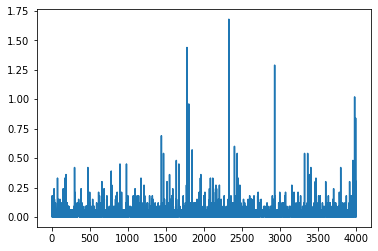

In [12]:
a = np.argmax(hoyle_model.predict(testre),axis=1)* 3/100
b = np.argmax(test_tarO,axis=1) * 3/100
plt.plot(np.abs(a-b))